# 사이킷런으로 수행하는 타이타닉 생존자 예측

캐글에서 제공하는 타이타틱 탑승자 데이터 기반으로
생존자 예측을 사이킷런으로 수행

타이타닉 생존자 데이터
- 머신러닝에 입문하는 데이터 분석가/과학자를 위한 기초 예제로 제공
- 많은 캐글 이용자가 자신의 방법으로 타이타닉 생존자 예측을 수행하고
- 수행 방법을 캐글에 공유

캐글 : 데이터 분석 오픝 포탈
    - 세계적인 ML 기반 분석 대회를 온라인 상에서 주관
    

# 사이킷런으로 수행하는 타이타닉 생존자 예측 과정
1. 데이터 정보 확인
2. 데이터 가공 (전처리)
    - Null 값 처리
    - Cabin 값 조정
    - 생존자 파악 (성별 / 객실등급별 / 연령별)
    - 레이블 인코딩
    - 모든 가공 내역을 함수로 작성
3. 생존자 예측 프로세스
    - 클래스 결정값 데이터 세트 만들기
    - 학습/테스트 데이터 세트 분리
    - 예측 수행
    - 교차 검증
    - 하이퍼 파라미터 튜닝

데이터 다운로드
https://www.kaggle.com/c/titanic/data

___
## 1. 데이터 정보 확인

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

titanic_df = pd.read_csv('210722_머신러닝06_titanic/titanic_train.csv')
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


- Passengerid: 탑승자 데이터 일련번호
- survived: 생존 여부, 0 = 사망, 1 = 생존
- Pclass: 티켓의 선실 등급, 1 = 일등석, 2 = 이등석, 3 = 삼등석
- sex: 탑승자 성별
- name: 탑승자 이름
- Age: 탑승자 나이
- sibsp: 같이 탑승한 형제자매 또는 배우자 인원수
- parch: 같이 탑승한 부모님 또는 어린이 인원수
- ticket: 티켓 번호
- fare: 요금
- cabin: 선실 번호
- embarked: 중간 정착 항구 C = Cherbourg, Q = Queenstown, S = Southampton

In [3]:
# 데이터 컬럼 타입 확인
print('데이터 정보\n')
print(titanic_df.info())

데이터 정보

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


데이터 정보 확인
- RangeIndex: 891 entries, 0 to 890 : 전체 행 (891개 행)
- Data columns (total 12 columns): 칼럼 수 (12개)
- float64 : 2개
- int64 : 5개
- object(string) : 5개
 - (판다스는 넘파이 기반으로 만들어졌는데
 - 넘파이의 String 타입의 길이 제한이 있기 때문에 
 - 이에 대한 구분을 위해 object 타입으로 명기)
- Age : 714개 (Null값(NaN): 177개)
- Cabin : 204개 (Null값(NaN): 687개)
- Embarked : 889개 (Null값(NaN): 2개)

In [4]:
# Null 값 개수 확인
titanic_df['Age'].isnull().sum()

177

In [5]:
titanic_df['Cabin'].isnull().sum()

687

In [6]:
titanic_df['Embarked'].isnull().sum()

2

___
## 2. 데이터 가공 (전처리)

### Null 컬럼들에 대한 처리
- 사이킷 머신러닝 알고리즘은 Null 값을 허용하지 않으므로
- Null 값을 어떻게 처리할지 결정
- DataFrame의 fillna() 메서드를 사용해서
- Null 값을 평균 또는 고정값으로 변경
- Age : 평균 나이로 변경
- 나머지 컬럼 : 'N'으로 변경

In [7]:
# Null 처리
titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace=True)
titanic_df['Cabin'].fillna('N', inplace=True)
titanic_df['Embarked'].fillna('N', inplace=True)

# 모든 컬럼의 Null 값을 합산해서 Null 값이 없는지 확인
print('각 칼럼의 Null 값 개수 : ', titanic_df.isnull().sum())
print('데이터 세트 Null 값 개수 : ', titanic_df.isnull().sum().sum())

각 칼럼의 Null 값 개수 :  PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64
데이터 세트 Null 값 개수 :  0


In [8]:
# 문자열 피처(Sex, Cabin, Embarked) 값 분류 확인
print('Sex 값 분포 : \n', titanic_df['Sex'].value_counts())
print('\nCabin 값 분포 : \n', titanic_df['Cabin'].value_counts())
print('\nEmbarked 값 분포 : \n', titanic_df['Embarked'].value_counts())

Sex 값 분포 : 
 male      577
female    314
Name: Sex, dtype: int64

Cabin 값 분포 : 
 N              687
G6               4
C23 C25 C27      4
B96 B98          4
F2               3
              ... 
D21              1
A24              1
D19              1
C118             1
A19              1
Name: Cabin, Length: 148, dtype: int64

Embarked 값 분포 : 
 S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64


문자열 피처 (Sex, Cabin, Embarked) 값 분류 설명  
Sex,Embarked 값은 별 문제 없음  
Cabin 값 분포 중에서 'C23 C25 C27' : '선실등급+번호'로 표기  
▶︎ 선실 등급만(첫 번째 문자)만 추출 필요

### Cabin 값 조정

In [9]:
# Cabin 칼럼 값 중에서 첫 번째 문자만 추출
titanic_df['Cabin'].str[0]

0      N
1      C
2      N
3      C
4      N
      ..
886    N
887    B
888    N
889    C
890    N
Name: Cabin, Length: 891, dtype: object

In [10]:
# Cabin 칼럼 값 중에서 첫 번째 문자만 추출
titanic_df['Cabin'].str[:1]

0      N
1      C
2      N
3      C
4      N
      ..
886    N
887    B
888    N
889    C
890    N
Name: Cabin, Length: 891, dtype: object

In [11]:
# Cabin 값을 선실등급만으로 표기 (선실 번호 제외)
titanic_df['Cabin'] = titanic_df['Cabin'].str[0]
print(titanic_df['Cabin'].head())

0    N
1    C
2    N
3    C
4    N
Name: Cabin, dtype: object


In [12]:
# 선실등급 별 개수 확인
titanic_df['Cabin'].value_counts()

N    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64

### 생존자 파악 

머신러닝 알고리즘 적용해서 예측 수행하기 전에 데이터 탐색
- 어떤 유형의 승객이 생존 확률이 높았는지 확인
- 성별이 생존 확률에 어떤 영향을 미쳤는지 확인
- 성별에 따른 생존자 수 비교

In [13]:
# 성별(Sex) 분포 확인
titanic_df.groupby('Sex')['Sex'].count()

Sex
female    314
male      577
Name: Sex, dtype: int64

In [14]:
# 성별(Sex) 생존(Survived) 확인
# 사망 : 0
# 생존 : 1
    
# Survived 칼럼 : 레이블로 결정 클래스 값
titanic_df.groupby(['Sex', 'Survived'])['Survived'].count()

# 여자 : 314명 중 233명 생존 (약 74.2% 생존)
# 남자 : 577명 중 109명 생존 (약 18.6% 생존)

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

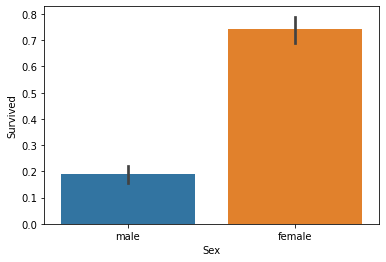

In [15]:
# 성별 생존자 : 막대 그래프 
sns.barplot(x='Sex', y='Survived', data=titanic_df)

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

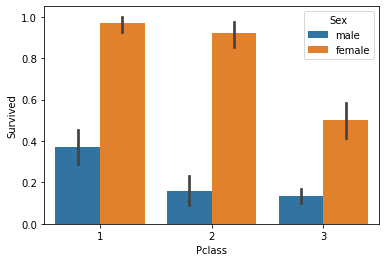

In [15]:
# 객실 등급별/성별 생존 확률
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=titanic_df)

# 여성 : 1,2등실에 따른 생존 확률의 차이는 크지 않으나
#          3등실의 경우 생존 확률이 상대적으로 떨어짐
# 남성 : 2,3등실 보다 1등실 생존 확률이 월등히 높음

In [16]:
# 연령(Age) 별 생존 확률 확인

# Age의 값 종류가 많기 때문에 범위별로 분류해 카테고리 값 할당

# 입력 age에  따라 구분값을 반환하는 함수 설정
# DataFrame의 apply()에서 lambda 식 사용
def get_category(age):
    cat = ''
    
    if age <= -1: cat = 'Unknown'              # -1 이하 오류 값
    elif age <= 5: cat = 'Baby'
    elif age <= 12: cat = 'Child'   
    elif age <= 18: cat = 'Teenager'
    elif age <= 25: cat = 'Student'
    elif age <= 35: cat = 'Young Adult'    
    elif age <= 60: cat = 'Adult'
    else : cat = 'Elderly'                     # 61세 이상
        
    return cat

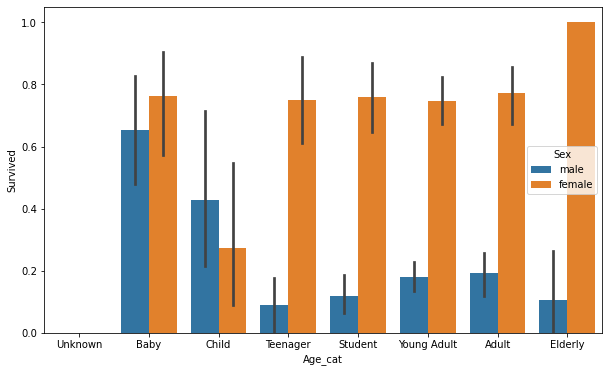

In [17]:
# 연령별 막대그래프로 출력

plt.figure(figsize=(10,6))

# X축의 값을 순차적으로 표시하기 위한 설정
group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']

# lambda 식에 위에서 생성한 get_category() 함수를 호출해서 반환값을 열로 저장
# get_category(X)는 입력값으로 'Age' 칼럼값을 받아서 해당하는 cat 반환
titanic_df['Age_cat'] = titanic_df['Age'].apply(lambda x: get_category(x))
sns.barplot(x='Age_cat', y='Survived', hue='Sex', data=titanic_df, order=group_names)
titanic_df.drop('Age_cat', axis=1, inplace=True)

### 레이블 인코딩

문자열 카테고리 피처를 숫자형 카테고리 피처로 변환
- 인코딩 : 사이킷런의 LabelEncoder 클래스 이용해서 레이블 인코딩 적용
- 0 ~ (카테고리 유형수 -1) 숫자값으로 변환
- fit() / transform() 메서드 사용

In [19]:
from sklearn import preprocessing

# 레이블 인코딩 함수 작성
def encode_features(dataDF):
    # 문자열 카테고리 피처
    features = ['Cabin', 'Sex', 'Embarked']
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(dataDF[feature])
        dataDF[feature] = le.transform(dataDF[feature])
    
    return dataDF

titanic_df = encode_features(titanic_df)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,7,3


### 모든 가공 내역 함수로 작성 (나중에 재사용 가능)

In [20]:
import pandas as pd

In [26]:
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩 수행 함수
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1] # 첫 문자만 추출
    
    features = ['Cabin', 'Sex', 'Embarked']
    
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    
    return df

# 위에서 만든 모든 함수를 한 번에 호출해서 사용하기 위한
# 함수 작성
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    
    return df

___
## 3. 생존자 예측 프로세스

### 클래스 결정값 데이터 세트 만들기

In [27]:
# 클래스 결정값(레이블) 데이터 세트 만들기

# 원본 데이터 재로딩
titanic_df = pd.read_csv('data/titanic_train.csv')

# 결정값 (Label)
y_titanic_df = titanic_df['Survived']

# 학습용 피처 데이터 세트
# 결정값으로 사용한 'Survived' 제외
X_titanic_df = titanic_df.drop('Survived', axis=1)

# 데이터 전처리 함수 호출
X_titanic_df = transform_features(X_titanic_df)
X_titanic_df.head(5)

# 생존자 예측을 수행할 피처 데이터 세트와 레이블 데이터 세트 완성

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,1,22.0,1,0,7.2500,7,3
1,1,0,38.0,1,0,71.2833,2,0
2,3,0,26.0,0,0,7.9250,7,3
3,1,0,35.0,1,0,53.1000,2,3
4,3,1,35.0,0,0,8.0500,7,3


### 학습 데이터 세트 분리

In [28]:
# 학습 / 테스트 데이터 세트 분리
# 테스트 데이터 세트 : 20 %

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

#### 생존자 예측  
  
3개의 ML 알고리즘 수행  
결정 트리, 랜덤 포레스트, 로지스틱 회귀(분류) 3개의 알고리즘으로 예측 수행하고 교차 검증으로 평가  

사이킷런 클래스
- 결정 트리 : DecisionTreeClassifier 
- 랜덤 포레스트 : RandomForestClassifier
- 로지스틱 회귀(분류): LogisticRegression
    
train_test_split()으로 분리한 학습 데이터와 테스트 데이터를 기반으로 머신러닝 모델을 학습하고(fit), 예측 수행(predict)  
예측 성능평가 : 정확도 (accuracy_score() 사용)  

#### 참고
  
결정 트리  
학습을 통해 데이터에 있는 규칙을 자동으로 찾아내 트리 기반의 분류 규칙을 만드는 알고리즘  
  
랜덤 포레스트  
대표적인 앙상블 알고리즘 같은 알고리즘으로 여러 개의 분류기를 만들어서 보팅으로 최종 결정하는 알고리즘  
  
로지스틱 회귀  
선형 회귀 방식을 분류에 적용한 알고리즘 선형 회귀 방식을 기반으로 하되 시그모이드 함수를 이용해 분류 수행
  
앙상블 학습 (Ensemble Learning)  
여러 개의 분류기를 사용해서 예측 결합함으로써 보다 정확한 최종 예측을 도출하는 기법

### 예측 수행

In [35]:
# 3개의 ML 알고리즘 사용해서 학습/예측/평가 수행

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 결정트리, 랜덤 포레스트, 로지스틱 회귀를 위한
# 사이킷런 Classifier 객체 생성
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression()

# DecisionTreeClassifier 학습/예측/평가
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
print('DecisionTreeClassifier 정확도 : {0:.4f}'.format(accuracy_score(y_test, dt_pred)))

# RandomForestClassifier 학습/예측/평가
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print('RandomForestClassifier 정확도 : {0:.4f}'.format(accuracy_score(y_test, rf_pred)))

# LogisticRegression 학습/예측/평가
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
print('LogisticRegression 정확도 : {0:.4f}'.format(accuracy_score(y_test, lr_pred)))

# RandomForestClassifier 정확도 : 0.8547 가 가장 높음
# 아직 최적화 작업을 수행하지 않았고
# 데이터 양도 충분하지 않기 때문에
# 어떤 알고리즘이 가장 성능이 좋다고 평가할 수 없음

DecisionTreeClassifier 정확도 : 0.7877
RandomForestClassifier 정확도 : 0.8547
LogisticRegression 정확도 : 0.8492


C:\Users\i3\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 교차 검증
교차 검증으로 결정 트리 모델 좀 더 평가  
사이킷런 model_selection 패키지의 KFold, cross_val_score(), GridSearchCV 클래스 사용

In [38]:
# 결정 트리 모델에 대해 KFold 클래스를 이용해 교차 검증 수행
# 폴드 개수 : 5

from sklearn.model_selection import KFold

def exec_kfold(clf, folds):
    # 폴드 세트가 5개인 KFold 객체 생성
    kfold = KFold(n_splits=folds)
    # 예측 평균 정확도 저장을 위한 리스트 객체 생성
    scores = []
    
    # KFold 교차 검증 수행 : enumerate(), iter_count(자동 증가) 사용
    for iter_count, (train_index, test_index) in enumerate(kfold.split(X_titanic_df)):
        # X_titanic_df 데이터에서 교차 검증별로 학습/검증 데이터를 가리키는 index 생성
        X_train, X_test = X_titanic_df.values[train_index], X_titanic_df.values[test_index] # 피처 데이터 
        y_train, y_test = y_titanic_df.values[train_index], y_titanic_df.values[test_index] # 레이블(타깃) 데이터
        
        # Classifier 학습/예측/정확도 계산
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, pred)
        scores.append(accuracy)
        
        print('교차 검증 {0} 정확도 :{1:.4f}'.format(iter_count, accuracy))
    
    # 5개 폴드에서 평균 정확도 계산
    mean_score = np.mean(scores)
    print('평균 정확도 {0:.4f}'.format(mean_score))
    
exec_kfold(dt_clf, folds=5)

교차 검증 0 정확도 :0.7542
교차 검증 1 정확도 :0.7809
교차 검증 2 정확도 :0.7865
교차 검증 3 정확도 :0.7697
교차 검증 4 정확도 :0.8202
평균 정확도 0.7823


In [41]:
# cross_val_score() 이용해서 교차 검증 수행
from sklearn.model_selection import cross_val_score

# cross_val_score(estimator, data, label, 폴드 수)
scores = cross_val_score(dt_clf, X_titanic_df, y_titanic_df, cv=5)

for iter_count, accuracy in enumerate(scores):
    print('교차 검증 {0} 정확도 :{1:.4f}'.format(iter_count, accuracy))
    
print('평균 정확도 {0:.4f}'.format(np.mean(scores)))

# 결과
# 앞에서 수행한 K 폴드 교차 검증 결과 : 평균 정확도 0.7823
# cross_val_score() : 평균 정확도 0.7879  (약간 더 높음)
# 높은 이유 : cross_val_score() StratifiedKFold를 이용해서 폴드 세트를 분할하기 때문에

교차 검증 0 정확도 :0.7430
교차 검증 1 정확도 :0.7753
교차 검증 2 정확도 :0.7921
교차 검증 3 정확도 :0.7865
교차 검증 4 정확도 :0.8427
평균 정확도 0.7879


### GridSearchCV 클래스를 이용해 하이퍼 파라미터 튜닝

In [42]:
# DecisionTreeClassifier의 최적 하이퍼 파라미터를 찾고 예측 성능 측정
# CV : 5개 폴드 세트 지정
# 하이퍼 파라미터 : max_depth, min_samples_split,min_samples_leaf
# 하이퍼 파라미터 값을 변경하면서 성능 측정
# 최적 하이퍼 파라미터와 그때의 예측 출력하고
# 최적 하이퍼 파라미터로 학습된 extimator를 이용해
# 분리된 테스트 데이터 세트에 예측을 수행해서
# 예측 정확도 출력

from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터설정
parameters = {'max_depth':[2, 3, 4, 10],
             'min_samples_split':[2, 3, 5],
             'min_samples_leaf':[1, 5, 8]}

grid_dclf = GridSearchCV(dt_clf, param_grid=parameters, scoring='accuracy', cv=5)
grid_dclf.fit(X_train, y_train)

print('GridSearchCV 최적 하이퍼 파라미터 : ', grid_dclf.best_params_)
print('GridSearchCV 최고 정확도 : {0:.4f} : '.format(grid_dclf.best_score_))

best_dclf = grid_dclf.best_estimator_

# 최적 하이퍼 파라미터로 학습된 Estimator 예측/평가 수행
pred = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('테스트 데이터 세트에서의 DecisionTreeClassifier 정확도 : {0:.4f}'.format(accuracy))

GridSearchCV 최적 하이퍼 파라미터 :  {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
GridSearchCV 최고 정확도 : 0.7992 : 
테스트 데이터 세트에서의 DecisionTreeClassifier 정확도 : 0.8715


**결과**  
최적의 하이퍼 파라미터로 학습시킨 뒤 예측 정확도가 87.15 %로 향상되었음 (78.79 %)  
하이퍼 파라미터 변경 전 보다 약 8% 이상 증가  
  
일반적으로 하이퍼 파라미터를 튜닝하더라도 이정도 수준으로 증가하기 매우 어려움  
테스트용 데이터 세트가 작기 때문에 수치상으로 예측 성능이 많이 증가한 것으로 보임  